In [1]:
using DrWatson
@quickactivate "BayesWorkshop2021"
include(joinpath(srcdir(), "setup.jl"));

## Expanding the model: multiple predictors

Modeling the relationship between complaints and bait stations is the simplest  model. We can expand the model, however, in a few ways that will be beneficial  for our client. Moreover, the manager has told us that they expect there are a number of other reasons that one building might have more roach complaints than another.

### Interpretability

Currently, our model's mean parameter is a rate of complaints per 30 days, but
we're modeling a process that occurs over an area as well as over time. We have
the square footage of each building, so if we add that information into the
model, we can interpret our parameters as a rate of complaints per square foot
per 30 days.

$$
\begin{align*}
\textrm{complaints}_{b,t} & \sim \textrm{Poisson}(\textrm{sq_foot}_b\,\lambda_{b,t}) \\
\lambda_{b,t} & = \exp{(\eta_{b,t} )} \\
\eta_{b,t} &= \alpha + \beta \, \textrm{traps}_{b,t}
\end{align*}
$$

The term $\text{sq_foot}$ is called an exposure term. If we log the term, we can 
put it in $\eta_{b,t}$:

$$
\begin{align*}
\textrm{complaints}_{b,t} & \sim \textrm{Poisson}(\lambda_{b,t}) \\
\lambda_{b,t} & = \exp{(\eta_{b,t} )} \\
\eta_{b,t} &= \alpha + \beta \, \textrm{traps}_{b,t} + \textrm{log_sq_foot}_b
\end{align*}
$$

A quick test shows us that there appears to be a relationship between the square
footage of the building and the number of complaints received:

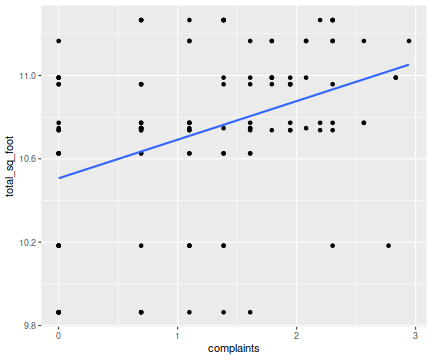

RObject{VecSxp}


┌ Warning: RCall.jl: `geom_smooth()` using formula 'y ~ x'
└ @ RCall /home/tor/.julia/packages/RCall/iMDW2/src/io.jl:160


In [2]:
using RCall
using StatsFuns

ggplot = rimport("ggplot2")
ggplot.ggplot(
    select(
        pest_data,
        :complaints => ByRow(StatsFuns.log1p),
        :total_sq_foot => ByRow(log),
        renamecols=false
    ),
    ggplot.aes(x = :complaints, y = :total_sq_foot)
) + ggplot.geom_point() + ggplot.geom_smooth(method = "lm", se = false)

Using the property manager's intuition, we include two extra pieces of information we know about the building - the (log of the) square floor space and whether there is a live in super or not - into both the simulated and real data.

In [3]:
transform!(pest_data, :total_sq_foot => ByRow(total_sq_foot -> log(total_sq_foot / 1e4)) => :log_sq_foot)

,mus,building_id,wk_ind,date,traps,floors,sq_footage_p_floor,live_in_super
,Float64,Int32,Int32,Date,Int64,Int64,Float64,Bool
1,0.369134,37,1,2017-01-15,8,8,5149.01,0
2,0.359355,37,2,2017-02-14,8,8,5149.01,0
3,0.281783,37,3,2017-03-16,9,8,5149.01,0
4,0.129254,37,4,2017-04-15,10,8,5149.01,0
5,0.452041,37,5,2017-05-15,11,8,5149.01,0
6,0.44213,37,6,2017-06-14,11,8,5149.01,0
7,0.990865,37,7,2017-07-14,10,8,5149.01,0
8,0.785977,37,8,2017-08-13,10,8,5149.01,0
9,0.691797,37,9,2017-09-12,9,8,5149.01,0


### Simulate fake data with multiple predictors


And then fit the model we wrote for the multiple regression.

In [4]:
using Turing

@model function multiple_poisson_regression(; traps, live_in_super, log_sq_foot, complaints=missing)
    beta ~ Normal(-0.25, 1)
    beta_super ~ Normal(-0.5, 1)
    alpha ~ Normal(log(4), 1)

    # Allocate if we're going to sample.
    complaints = complaints === missing ? Vector{Int}(undef, length(traps)) : complaints
    @. complaints ~ Poisson(exp(alpha + beta * traps + beta_super * live_in_super + log_sq_foot))
    return (; alpha, beta, beta_super, complaints)
end

multiple_poisson_regression (generic function with 1 method)

Again we'll generate some samples from the prior to get a better sense of what asusmptions we've actually encoded in the model:

In [5]:
N = size(pest_data, 1)
mean_traps = mean(pest_data.traps)
fake_traps = rand(filldist(Poisson(mean_traps), N))
fake_obs = (
    traps = fake_traps,
    live_in_super = rand(filldist(Bernoulli(0.5), N)),
    log_sq_foot = rand(filldist(Normal(1.5, 0.1), N)),
)

(traps = [10, 12, 10, 8, 5, 5, 9, 6, 7, 6  …  6, 13, 6, 12, 6, 9, 11, 4, 3, 4], live_in_super = Bool[1, 0, 1, 0, 1, 0, 0, 0, 1, 0  …  0, 0, 1, 0, 0, 0, 0, 0, 0, 1], log_sq_foot = [1.5402399979843977, 1.5425372056256093, 1.381070692832613, 1.511630975757052, 1.3655027131290263, 1.5426339439792278, 1.4216374618172534, 1.564843269867859, 1.482344540326858, 1.3720762963614122  …  1.4073903410521562, 1.473716453712855, 1.5328542358768633, 1.384630700443407, 1.527035364320064, 1.4250473961493295, 1.5810103406221736, 1.5153265545632197, 1.3676119778291342, 1.36799427864984])

In [6]:
fake_data = multiple_poisson_regression(; fake_obs...)()

(alpha = 3.026391157966192, beta = -1.688410437108499, beta_super = -1.3462183844128301, complaints = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

Then compare these parameters to the true parameters:

In [7]:
fake_post = sample(multiple_poisson_regression(; fake_obs..., complaints=fake_data.complaints), NUTS(), 1_000);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/tor/.julia/packages/Turing/YGtAo/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


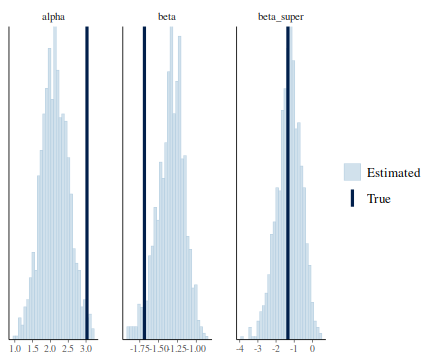

RObject{VecSxp}


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/tor/.julia/packages/RCall/iMDW2/src/io.jl:160


In [8]:
mcmc_recover_hist(
    fake_post,
    (
        alpha = fake_data.alpha,
        beta = fake_data.beta,
        beta_super = fake_data.beta_super
    )
)

We've recovered the parameters sufficiently well, so we've probably coded the model correctly and we're ready to fit the real data.

### Fit the real data

Now let's use the real data and explore the fit.

In [9]:
obs = (
    traps = pest_data.traps,
    live_in_super = pest_data.live_in_super,
    log_sq_foot = pest_data.log_sq_foot
)
post = sample(multiple_poisson_regression(; obs..., complaints=pest_data.complaints), NUTS(), 1_000);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false,

In [10]:
yrep = posterior_predictive(multiple_poisson_regression(; obs...), post)

1000-element Vector{NamedTuple{(:complaints,), Tuple{SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}}}:
 (complaints = [1.0, 2.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 5.0  …  2.0, 2.0, 1.0, 2.0, 7.0, 4.0, 7.0, 12.0, 4.0, 6.0],)
 (complaints = [2.0, 1.0, 1.0, 1.0, 4.0, 0.0, 1.0, 1.0, 3.0, 4.0  …  4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 6.0, 8.0, 9.0, 8.0],)
 (complaints = [5.0, 4.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 3.0, 4.0  …  3.0, 2.0, 5.0, 5.0, 6.0, 9.0, 9.0, 7.0, 11.0, 7.0],)
 (complaints = [1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0  …  4.0, 5.0, 4.0, 5.0, 6.0, 6.0, 15.0, 9.0, 10.0, 11.0],)
 (complaints = [2.0, 5.0, 2.0, 3.0, 1.0, 2.0, 3.0, 0.0, 4.0, 2.0  …  2.0, 5.0, 6.0, 4.0, 8.0, 6.0, 3.0, 7.0, 9.0, 10.0],)
 (complaints = [1.0, 4.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 3.0, 1.0  …  3.0, 5.0, 7.0, 6.0, 6.0, 7.0, 6.0, 13.0, 8.0, 8.0],)
 (complaints = [3.0, 2.0, 9.0, 3.0, 2.0, 0.0, 2.0, 5.0, 2.0, 4.0  …  1.0, 5.0, 4.0, 2.0, 5.0, 10.0, 10.0, 8.0, 7.0, 5.0],

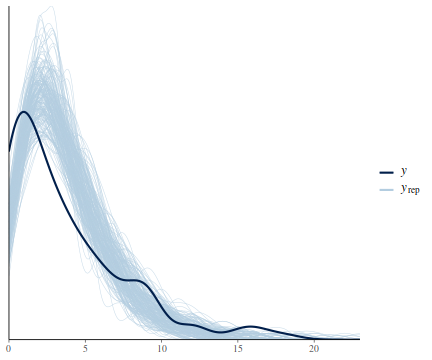

RObject{VecSxp}


In [11]:
ppc_dens_overlay(pest_data.complaints, yrep[1:200])

This again looks like we haven't captured the smaller counts very well, nor have we captured the larger counts.

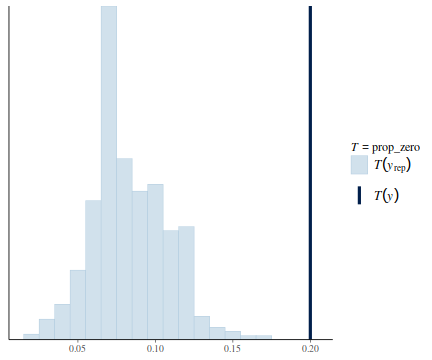

RObject{VecSxp}


In [12]:
R"""
prop_zero <- function(x) mean(x == 0)
"""

ppc_stat(pest_data.complaints, yrep, stat = "prop_zero", binwidth = 0.01)

We're still severely underestimating the proportion of zeros in the data. Ideally this vertical line would fall somewhere within the histogram.

We can also plot uncertainty intervals for the predicted complaints for different numbers of traps.

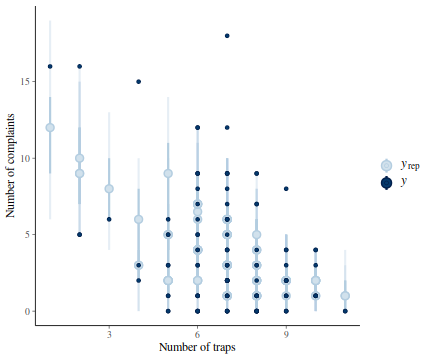

RObject{VecSxp}


In [13]:
ppc_intervals(pest_data.complaints, yrep, x = pest_data.traps) + ggplot.labs(x = "Number of traps", y = "Number of complaints")

We can see that we've increased the tails a bit more at the larger numbers of traps but we still have some large observed numbers of complaints that the model would consider extremely unlikely events.